In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
basetable = pd.read_csv("data/basetable_.csv")

In [3]:
basetable.head()

,dim_height,dim_width,dim_depth,dim_weight,display_size,num_usb,num_hdmi,display_type,energyclass,display_resolution,...,is_company_gaba,is_company_nokia,is_company_vortex,is_company_smart,is_company_strong,dim_density,display_pixeldensity,display_relativeenergy,price,serial_id
0,56.00,95.70,4.40,NaN,43.0,1.0,3.0,5.0,5.0,1.0,...,0,0,0,0,0,NaN,0.386923,345.6,119998.9980,274435
1,78.80,123.50,26.00,NaN,55.0,2.0,3.0,1.0,NaN,1.0,...,0,0,0,0,0,NaN,0.213075,NaN,199999.0031,276494
2,NaN,NaN,NaN,7.5,43.0,2.0,3.0,4.0,5.0,1.0,...,0,0,0,0,0,NaN,NaN,345.6,109999.0053,275834
3,46.90,73.00,18.80,3.9,32.0,2.0,2.0,4.0,5.0,3.0,...,0,0,0,0,0,0.000061,9.690569,5529.6,47999.0023,271832
4,91.58,144.75,30.85,19.6,65.0,1.0,3.0,4.0,5.0,1.0,...,0,0,0,0,0,0.000048,0.156425,345.6,194999.0004,274692


In [4]:
pd.DataFrame({
    "dtypes": basetable.dtypes,
    "num_nans": basetable.isna().sum()},
    index = basetable.columns
).sort_values(
    by="num_nans", 
    ascending=False
)

,dtypes,num_nans
dim_density,float64,183
dim_weight,float64,169
display_pixeldensity,float64,124
dim_height,float64,122
dim_depth,float64,122
dim_width,float64,122
dim_color,float64,120
num_usb,float64,57
display_relativeenergy,float64,57
energyclass,float64,54


<Axes: >

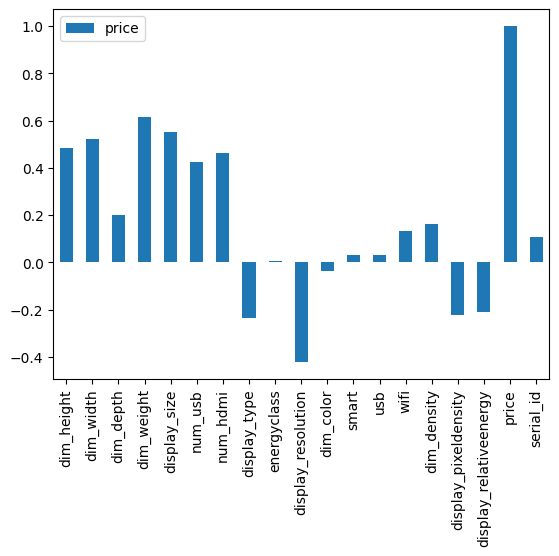

In [5]:
basetable.corr()[["price"]].loc[[col for col in basetable.columns if ("is_company" not in col)]].plot.bar()

<Axes: >

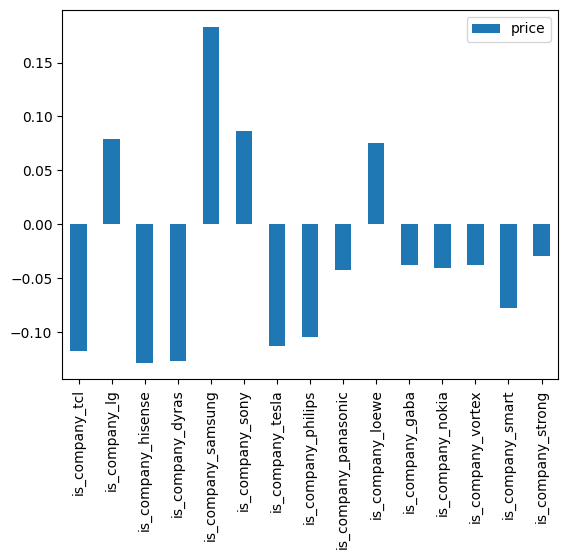

In [6]:
basetable.corr()[["price"]].loc[[col for col in basetable.columns if ("is_company" in col)]].plot.bar()

# Preprocessing

In [7]:
basetable["logprice"] = np.log(basetable["price"])

In [8]:
(basetable["serial_id"] % 5).value_counts() # can hold as split value

serial_id
4    84
2    84
0    81
1    81
3    79
Name: count, dtype: int64

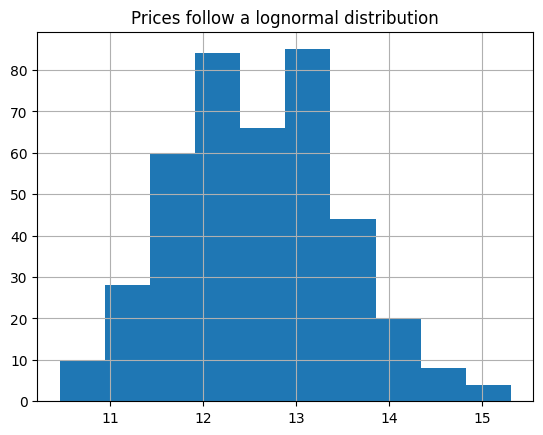

In [9]:
basetable.logprice.hist()
plt.title("Prices follow a lognormal distribution")
plt.show()

<Axes: >

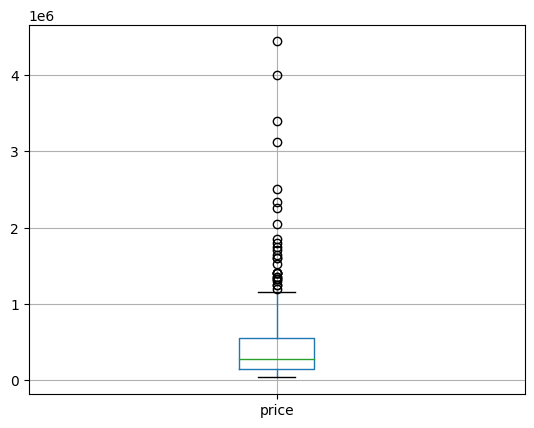

In [10]:
# although there are extreme values then do not seem to have signifikance in the lognormal distribution -> keep them
basetable[["price"]].boxplot() 

In [11]:
def split(df,target="log"):
    X = df.drop(columns=["price","logprice","serial_id"])
    y = None
    if target == "log":
        y = df["logprice"]
    else:
        y = df["price"]
    return (X,y)

In [12]:
cutoff = np.quantile(basetable["price"], 0.95)
X = basetable.query("price < @cutoff")
len(X), len(basetable)

(388, 409)

0         Axes(0.1,0.679412;0.363636x0.220588)
1    Axes(0.536364,0.679412;0.363636x0.220588)
2         Axes(0.1,0.414706;0.363636x0.220588)
3    Axes(0.536364,0.414706;0.363636x0.220588)
4             Axes(0.1,0.15;0.363636x0.220588)
dtype: object

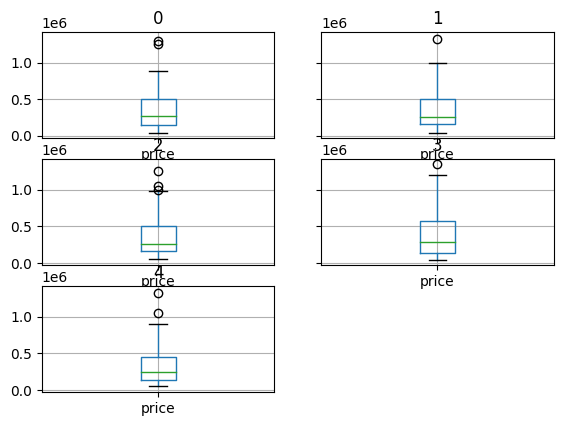

In [13]:
X.set_index("serial_id").groupby(lambda i: i%5)[["price"]].boxplot()

In [14]:
X_test, y_test = split(X.query("serial_id % 5 == 0"))

X_inner, y_inner = split(X.query("serial_id % 5 == 1"))

X_train, y_train = split(X.query("serial_id % 5 not in [0,1]"))

# Linear regression: baseline

In [15]:
from sklearn.impute import SimpleImputer
from sklearn.linear_model import ElasticNet

from sklearn.pipeline import Pipeline

In [16]:
filler = SimpleImputer(strategy='median')

In [17]:
linreg = ElasticNet(
    alpha = 1.0,
    l1_ratio = 0.5,
    random_state = 42
)

In [18]:
pipe = Pipeline([("median-filler",filler),("linreg",linreg)])

In [19]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('median-filler', SimpleImputer(strategy='median')),
                ('linreg', ElasticNet(random_state=42))])

In [20]:
# R2 score
pipe.score(X_test, y_test)

0.5746706644905732

In [21]:
preds = pipe.predict(X_test)
rmse = mean_squared_error(y_test, preds) ** 0.5
rmse

0.49637957594080173

In [22]:
preds = pipe.predict(X_test)
mean_squared_error(np.exp(y_test), np.exp(preds)) ** 0.5

188136.99191997034

In [23]:
preds = pipe.predict(X_test)
mean_absolute_error(np.exp(y_test), np.exp(preds))

123272.49121271592

# XGBRegressor

In [24]:
regressor = xgb.XGBRegressor(
    n_estimators = 100,
    objective = "reg:squarederror",
    eval_metric = "rmse",
    early_stopping_rounds = 10,
    n_jobs = -1,
    verbosity = 1,
)

In [25]:
search_space = {
    #booster
    "learning_rate": (0.001,0.01,0.1),
    #model complexity
    "max_depth": [3,5,7],
    #"min_child_weight": (0.01,0.75,10.0),
    "min_split_loss": (0.01,0.75,10.0),
    #regularization
    "reg_alpha": (0.01,0.75,10.0),
    "reg_lambda": (0.001,0.1),
}

In [26]:
optimizer = GridSearchCV(
    estimator = regressor, 
    param_grid = search_space, 
    scoring = 'r2',
    cv = 3,
    refit = True,
    verbose = 1
)

In [27]:
# Train
fit_params = {
    "verbose" : 0,
    "eval_set": [(X_inner,y_inner)], # used for early stopping
}

In [28]:
%%time
optimizer.fit(X_train,y_train,**fit_params)

Fitting 3 folds for each of 162 candidates, totalling 486 fits
CPU times: user 10min 55s, sys: 8.2 s, total: 11min 3s
Wall time: 1min 38s


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=10,
                                    enable_categorical=False,
                                    eval_metric='rmse', feature_types=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=-1, num_parallel_tree=None,
                                    predictor=None, random_state=None, ...),
             param_grid={'learning_rate': (0.001, 0.01, 0.1),
                         'max_depth': [3, 5, 7],
                         'min_split_loss': (0.01, 0.75, 10.0),
                         'reg_alpha': (0.01, 0.75, 10.0),
                         'reg_lambda': (0.001, 0.1)},
             scoring='r2', verbose=1)

In [29]:
best_model = optimizer.best_estimator_
print(f"Best iteration: {best_model.best_iteration}/100")

print(f"RMSE (inner): {best_model.best_score:.4f}")
print(f"Mean R2-score on validation data with 3 folds: {optimizer.best_score_:.4f}")

Best iteration: 96/100
RMSE (inner): 0.3046
Mean R2-score on validation data with 3 folds: 0.8230


In [30]:
optimizer.best_params_

{'learning_rate': 0.1,
 'max_depth': 3,
 'min_split_loss': 0.01,
 'reg_alpha': 0.01,
 'reg_lambda': 0.1}

In [31]:
# R2 scores
best_model.score(X_test,y_test), best_model.score(X_inner,y_inner), best_model.score(X_train,y_train)

(0.8422005348804272, 0.8387127017305535, 0.9583253194068813)

In [32]:
best_model.save_model("models/xgbr_log_cutoff2.json")

# Investigate

In [33]:
X.dtypes

dim_height                float64
dim_width                 float64
dim_depth                 float64
dim_weight                float64
display_size              float64
num_usb                   float64
num_hdmi                  float64
display_type              float64
energyclass               float64
display_resolution        float64
dim_color                 float64
smart                       int64
usb                         int64
wifi                        int64
is_company_tcl              int64
is_company_lg               int64
is_company_hisense          int64
is_company_dyras            int64
is_company_samsung          int64
is_company_sony             int64
is_company_tesla            int64
is_company_philips          int64
is_company_panasonic        int64
is_company_loewe            int64
is_company_gaba             int64
is_company_nokia            int64
is_company_vortex           int64
is_company_smart            int64
is_company_strong           int64
dim_density   

In [34]:
preds = best_model.predict(X_test)

In [35]:
preds = best_model.predict(X_test)
rmse = mean_squared_error(y_test, preds) ** 0.5
rmse

0.30234584055284086

In [36]:
preds = best_model.predict(X_test)
mean_squared_error(np.exp(y_test), np.exp(preds)) ** 0.5

138742.72749807336

In [37]:
preds = best_model.predict(X_test)
mean_absolute_error(np.exp(y_test), np.exp(preds))

88971.60299113176

In [38]:
y_min, y_max = min(X["logprice"]), max(X["logprice"])
p_min, p_max = min(preds), max(preds)

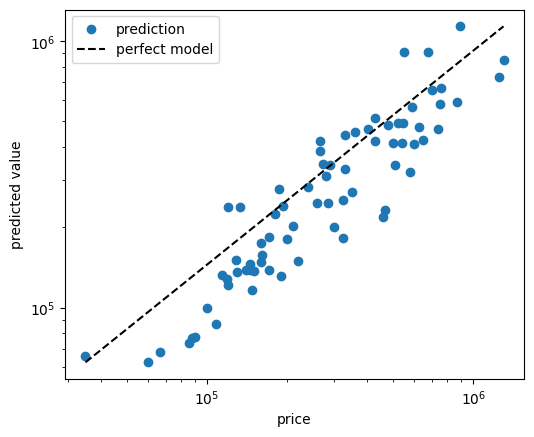

In [39]:
plt.scatter(
    np.exp(y_test),
    np.exp(preds),
    label="prediction"
)
plt.plot(
    np.exp([min(y_test),max(y_test)]),
    np.exp([min(preds),max(preds)]),
    "k--",label="perfect model"
)
plt.legend()

plt.xlabel("price")
plt.ylabel("predicted value")

plt.xscale("log")
plt.yscale("log")

plt.gca().set_aspect('equal', adjustable='box')

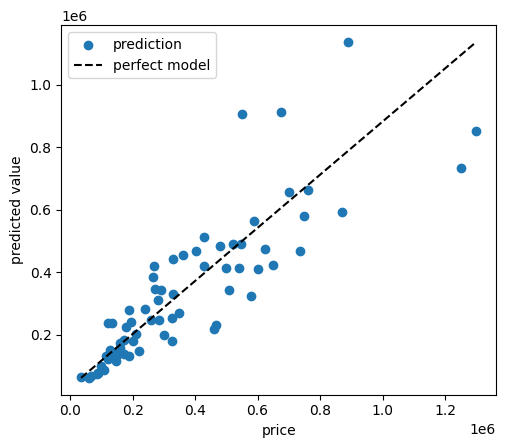

In [40]:
plt.scatter(
    np.exp(y_test),
    np.exp(preds),
    label="prediction"
)
plt.plot(
    np.exp([min(y_test),max(y_test)]),
    np.exp([min(preds),max(preds)]),
    "k--",label="perfect model"
)
plt.legend()

plt.xlabel("price")
plt.ylabel("predicted value")

plt.gca().set_aspect('equal', adjustable='box')

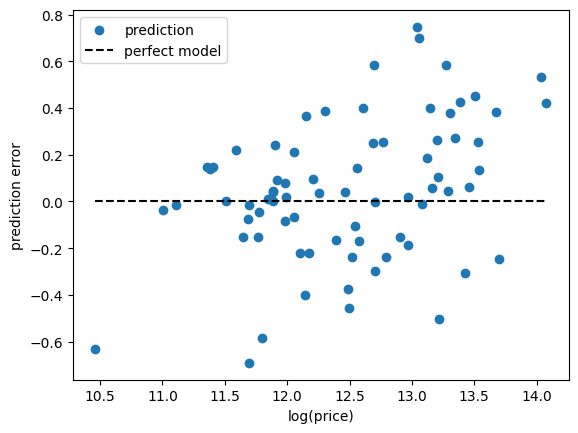

In [41]:
plt.scatter(y_test, y_test-preds, label="prediction")
plt.plot([min(y_test),max(y_test)],[0,0], "k--", label="perfect model")
plt.legend()

plt.xlabel("log(price)")
plt.ylabel("prediction error")

plt.show()

# Feature importances

In [42]:
from sklearn.inspection import permutation_importance

In [43]:
result = permutation_importance(best_model,X_train,y_train,scoring="r2")

In [44]:
result.keys()

dict_keys(['importances_mean', 'importances_std', 'importances'])

In [45]:
importances = pd.Series(result.importances_mean, index=X_train.columns)
std = result["importances_std"]

<Axes: >

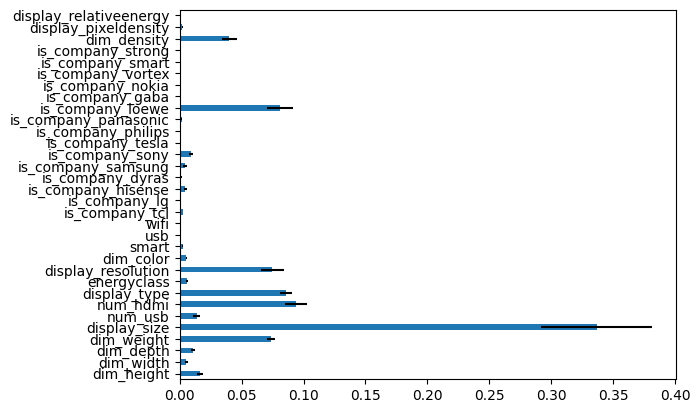

In [46]:
importances.plot.barh(xerr=std)